# Test pytorch implementation

In [1]:
# Load dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

from ontram_pytorch import OntramModel
from ontram_pytorch import fit_ontram, predict_ontram, classification_metrics

In [2]:
DIR = '/home/hezo/'
OUTPUT_DIR = DIR + 'ontram_pytorch/checkpoints_cifar10/'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    print(f"Created folder {OUTPUT_DIR}")
else:
    print(f"Folder {OUTPUT_DIR} already exists.")

Folder /home/hezo/ontram_pytorch/checkpoints_cifar10/ already exists.


# Data

In [3]:
# Define the transformations to apply to each image.
# For example, convert images to tensors and normalize them.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# one hot encode labels for ontram
def one_hot_encode_labels(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# Custom collate function to apply one-hot encoding
def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack images and labels
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to tensor
    labels = one_hot_encode_labels(labels)  # One-hot encode labels
    return images, labels

# consider only a subset
subset_indices = list(range(20000))
train_dataset_sub = Subset(train_dataset, subset_indices)
subset_indices = list(range(2000))
test_dataset_sub = Subset(test_dataset, subset_indices)

# Create train and test DataLoaders with the custom collate function
train_loader = DataLoader(train_dataset_sub, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset_sub, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Image batch shape: torch.Size([32, 3, 32, 32])
Label batch shape: torch.Size([32, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].


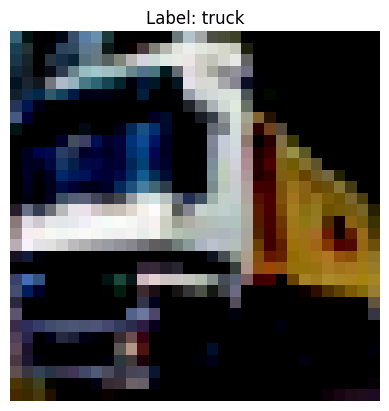

In [4]:
img_pt, label = train_dataset[1]
img = img_pt.numpy().transpose((1, 2, 0))

plt.imshow(img, interpolation='nearest')
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis('off')
plt.show()

In [5]:
print("Classes: ", train_dataset.classes)

Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Model

In [6]:
# Hyperparameters
device = 'cuda'
epochs = 20
lr = 0.001

#### General implementation

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = self.relu(self.fc1(x)) 
        x = self.dropout(x)  
        x = self.fc2(x)  
        return x

In [8]:
# Define model
model = SimpleCNN()
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # print("Batch loss: ", loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        _, true = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == true).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1, Loss: 1.7078850456237793
Epoch 2, Loss: 1.3427010618209838
Epoch 3, Loss: 1.167658680343628
Epoch 4, Loss: 1.0196236207008362
Epoch 5, Loss: 0.9211402674674988
Epoch 6, Loss: 0.8141905107498169
Epoch 7, Loss: 0.7290066030979157
Epoch 8, Loss: 0.6610491582870484
Epoch 9, Loss: 0.5990523226737976
Epoch 10, Loss: 0.5335206910848618
Epoch 11, Loss: 0.4817766573667526
Epoch 12, Loss: 0.43977753870487213
Epoch 13, Loss: 0.39883075156211856
Epoch 14, Loss: 0.36704229617118833
Epoch 15, Loss: 0.33183709685206414
Epoch 16, Loss: 0.3085206061542034
Epoch 17, Loss: 0.2892671183884144
Epoch 18, Loss: 0.26957514313459396
Epoch 19, Loss: 0.2505058567225933
Epoch 20, Loss: 0.24659470533132552
Test Accuracy: 69.35%


#### ontram implementation

In [10]:
# Create folder for model
MODEL_DIR = OUTPUT_DIR + 'csb/'

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    print(f"Created folder {MODEL_DIR}")
else:
    print(f"Folder {MODEL_DIR} already exists.")

Folder /home/hezo/ontram_pytorch/checkpoints_cifar10/csb/ already exists.


In [11]:
class SimpleCNN1(nn.Module):
    def __init__(self):
        super(SimpleCNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Output layer: Change number of classes to C-1=9 and bias=False
        self.fc2 = nn.Linear(256, 9, bias=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = self.relu(self.fc1(x)) 
        x = self.dropout(x)  
        x = self.fc2(x)  
        return x

In [12]:
ontram_model = OntramModel(SimpleCNN1())

# Slower in training (makes sense, we have no ordinal outcome here), learing rate has to be lower
fit_ontram(ontram_model, train_loader, 
           optimizer=torch.optim.Adam(ontram_model.parameters(), lr=0.0001), 
           epochs=epochs, checkpoint_path=MODEL_DIR, si=False)

Train with GPU support.


Epoch 1/20, Train Loss: 2.1765, Validation Loss: 0.0000
Epoch 2/20, Train Loss: 1.8134, Validation Loss: 0.0000
Epoch 3/20, Train Loss: 1.6828, Validation Loss: 0.0000
Epoch 4/20, Train Loss: 1.5964, Validation Loss: 0.0000
Epoch 5/20, Train Loss: 1.5353, Validation Loss: 0.0000
Epoch 6/20, Train Loss: 1.4936, Validation Loss: 0.0000
Epoch 7/20, Train Loss: 1.4505, Validation Loss: 0.0000
Epoch 8/20, Train Loss: 1.4074, Validation Loss: 0.0000
Epoch 9/20, Train Loss: 1.3744, Validation Loss: 0.0000
Epoch 10/20, Train Loss: 1.3330, Validation Loss: 0.0000
Epoch 11/20, Train Loss: 1.3045, Validation Loss: 0.0000
Epoch 12/20, Train Loss: 1.2766, Validation Loss: 0.0000
Epoch 13/20, Train Loss: 1.2425, Validation Loss: 0.0000
Epoch 14/20, Train Loss: 1.2158, Validation Loss: 0.0000
Epoch 15/20, Train Loss: 1.1858, Validation Loss: 0.0000
Epoch 16/20, Train Loss: 1.1598, Validation Loss: 0.0000
Epoch 17/20, Train Loss: 1.1342, Validation Loss: 0.0000
Epoch 18/20, Train Loss: 1.1113, Validat

{'train_loss': [2.1764887098312378,
  1.8133694383621215,
  1.6827516424179076,
  1.596358761405945,
  1.5353078927993775,
  1.4936164836883545,
  1.4505273359298707,
  1.4073696729660035,
  1.374352462863922,
  1.3329762325286865,
  1.304539942073822,
  1.276573459625244,
  1.24249857711792,
  1.215767066192627,
  1.1858263716697692,
  1.1598230562210083,
  1.1342203300476075,
  1.1112556621551513,
  1.0865833562850953,
  1.0591016373634339],
 'val_loss': []}

In [13]:
results = predict_ontram(ontram_model, test_loader, output='all', si=False)

In [14]:
y_test = []
for images, labels in test_loader:  # Assuming (images, labels) format
    y_test.extend(labels.numpy())  # Convert to numpy for easy handling
y_test = np.array(y_test)  # Convert to numpy array (optional)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
classification_metrics(results, y_test)

{'accuracy': 0.6315}